(644, 10)
(644,)
Best combination: max_depth=3, min_samples_split=2, min_samples_leaf=8, ccp_alpha=0.0
Corresponding Mean Squared Error: 0.022422084870210746
Corresponding R-squared: 0.5681868218346554
Length of X columns: 10
Length of feature importances: 10
              Feature  Importance
8             latent1    0.792433
9             latent2    0.151150
5           cab_count    0.031495
7                   W    0.016715
0          sq_cabinet    0.008208
1               sq_pm    0.000000
2             miw_new    0.000000
3  total_cabinet_size    0.000000
4         party_count    0.000000
6                enpp    0.000000


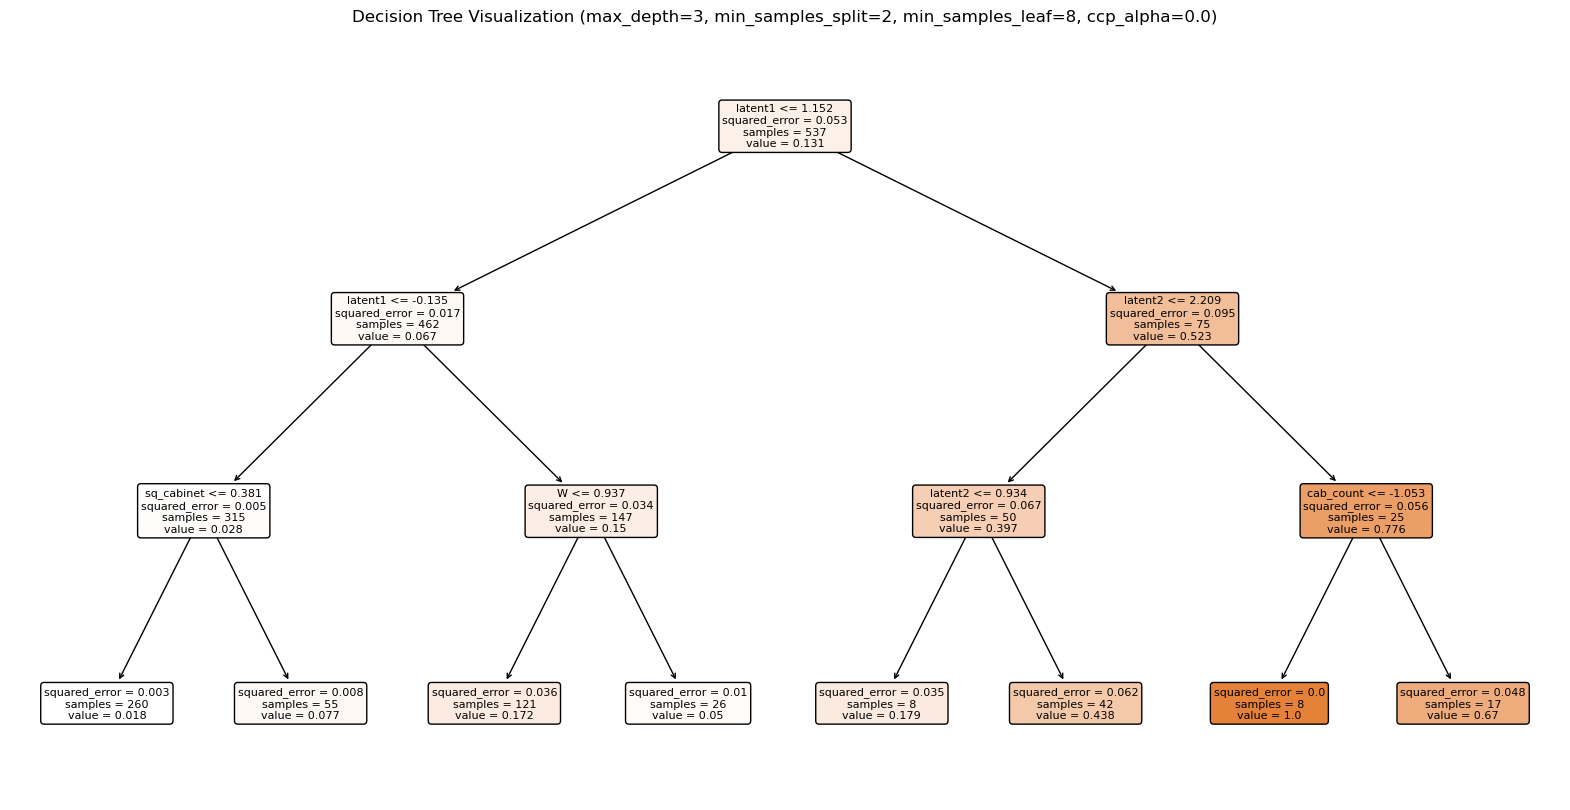

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

data = pd.read_csv('/Users/nick/Desktop/class_final_proportion.csv')

# Select subset of independent variables
pca1 = ['shapley', 'splus', 'banzhaf', 'miw_proportion'] 
pca2 = ['seats','seats_share','seats_proportion']
subset1_data = data[pca1]
subset2_data = data[pca2]


# Data preprocessing
scaler = StandardScaler()
subset1_scaled = scaler.fit_transform(subset1_data)
subset2_scaled = scaler.fit_transform(subset2_data)

# PCA on the subset
num_components = 3 
pca = PCA(n_components=num_components)
subset1_pca = pca.fit_transform(subset1_scaled)
subset2_pca = pca.fit_transform(subset2_scaled)


import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor, export_graphviz, plot_tree
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import warnings


df = pd.read_csv('/Users/nick/Desktop/class_final_proportion.csv')
df['latent1'] = subset1_pca[:, 0]
df['latent2'] = subset2_pca[:, 0]
list_to_drop = ['seats_total','base','party', 'election_year','country', 'cabinet_name','caretaker','cabinet_id','party_id','prime_minister','cabinet_party','left_righty','left_rightx','cabinet_seats','party_name','party_name_english','country_id','election_id','election_date','start_date','post_election','mingov','bicameral','largest_parl','largest_cab','lag_largest_parl','lag_largest_cab','A', 'B','B_star','C','D','E','country_dummy1','country_dummy2','country_dummy3','country_dummy4','country_dummy5','country_dummy6','country_dummy7','country_dummy8','country_dummy9','country_dummy10','country_dummy11','country_dummy12','country_dummy13','coalition_total']
c = ['cabinet_proportion']
df = df.drop(columns = list_to_drop)
df.dropna(inplace=True)

X = df.drop(columns=c+pca1+pca2)
print(X.shape)
y = df['cabinet_proportion']
print(y.shape)

# Impute missing values with knn
#imputer = KNNImputer(n_neighbors=10)
#X_imputed = imputer.fit_transform(X)


#k-fold cross-validation set up
kf = KFold(n_splits=6, shuffle=True)

# lists for max_depth, min_samples_split, min_samples_leaf, and ccp_alpha values iteration
max_depth_values = [3]
min_samples_split_values = [2, 5, 7]
min_samples_leaf_values = [1, 2, 4, 8]
ccp_alpha_values = [0.0, 0.01]

# for storing results for each comb of hyperparameters
results = {}

# for storing models for each comb of hyperparameters
models_mapping = {}

#i get a lot of warnings when I run the code so this hides them
warnings.filterwarnings("ignore", category=UserWarning)

# iterate through different max_depth, min_samples_split, min_samples_leaf, and ccp_alpha values
for max_depth in max_depth_values:
    for min_samples_split in min_samples_split_values:
        for min_samples_leaf in min_samples_leaf_values:
            for ccp_alpha in ccp_alpha_values:
                mse_scores = []
                r_squared_scores = []

                # perform k-fold
                for train_index, test_index in kf.split(X):
                    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                    #X_train, X_test = X_imputed[train_index], X_imputed[test_index]
                    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

                    # standardize train and test
                    scaler = StandardScaler()
                    X_train_scaled = scaler.fit_transform(X_train)
                    X_test_scaled = scaler.transform(X_test)

                    # decision tree regression model with hyperparameters and ccp pruning
                    dt_model = DecisionTreeRegressor(
                        max_depth=max_depth,
                        min_samples_split=min_samples_split,
                        min_samples_leaf=min_samples_leaf,
                        ccp_alpha=ccp_alpha,
                        random_state=42
                    )

                    # fit the model on training data
                    dt_model.fit(X_train_scaled, y_train)

                    # make predictions on the test set
                    y_pred = dt_model.predict(X_test_scaled)

                    # eval the model
                    mse = mean_squared_error(y_test, y_pred)
                    mse_scores.append(mse)

                    # calc R-squared
                    r_squared = r2_score(y_test, y_pred)
                    r_squared_scores.append(r_squared)

                # calc avg MSE and R-squared across folds
                avg_mse = np.mean(mse_scores)
                avg_r_squared = np.mean(r_squared_scores)

                # store the results for this combination of hyperparameters
                results[(max_depth, min_samples_split, min_samples_leaf, ccp_alpha)] = (avg_mse, avg_r_squared)

                # store the model for this combination of hyperparameters
                models_mapping[(max_depth, min_samples_split, min_samples_leaf, ccp_alpha)] = dt_model

# combination of hyperparameters that maximizes R-squared
best_combination = max(results, key=lambda x: results[x][1])
best_mse, best_r_squared = results[best_combination]

# print the best combination and its corresponding MSE and R-squared
print(f'Best combination: max_depth={best_combination[0]}, min_samples_split={best_combination[1]}, min_samples_leaf={best_combination[2]}, ccp_alpha={best_combination[3]}')
print(f'Corresponding Mean Squared Error: {best_mse}')
print(f'Corresponding R-squared: {best_r_squared}')

# ccess the best model using the best combination of hyperparameters
best_model = models_mapping[best_combination]

# feature importances
feature_importances = best_model.feature_importances_

# Check the lengths of X columns and feature importances
print("Length of X columns:", len(X.columns))
print("Length of feature importances:", len(feature_importances))

# Ensure alignment of feature importances with X columns
if len(X.columns) != len(feature_importances):
    print("Error: Lengths of X columns and feature importances are not equal.")
else:
    # Create a DataFrame to display feature importances
    feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

    # Sort df by importance in descending order
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Display the feature importances
    print(feature_importance_df)

    # Show the decision tree with the best combination of hyperparameters
    plt.figure(figsize=(20, 10))
    plot_tree(best_model, filled=True, feature_names=X.columns.tolist(), rounded=True, fontsize=8)
    plt.title(f'Decision Tree Visualization (max_depth={best_combination[0]}, min_samples_split={best_combination[1]}, min_samples_leaf={best_combination[2]}, ccp_alpha={best_combination[3]})')
    plt.show()